In [1]:
import numpy as np
import gensim, logging
import csv, string
import nltk
#nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
import pandas as pd
import tensorflow as tf
import os
import pickle

num_words = 400
num_words_description = 400
directory_prefix = "../"
train_dataset_path = directory_prefix+'datasets/dataset2002-2020.csv'
test_dataset_path = directory_prefix+'datasets/balanced_test_dataset_label_depth_3.csv'
label_depth = 3
import random
#import gensim.downloader as api
from nltk.corpus import stopwords
from gensim.parsing.preprocessing import remove_stopwords


import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1")
#embed = hub.load("https://tfhub.dev/google/Wiki-words-500/2")

embeddings = embed(["cat is on the mat", "dog is in the fog"])
embedding_dim = embeddings.shape[1]
#print(embeddings)
def get_sentence_vector(words, num_words):
    words = word_tokenize(remove_stopwords(words))
    #words = list(filter(lambda w: len(w)>2, words))
    ret = embed(words)
    ret = tf.pad(ret, tf.constant([[0, max(0, num_words-ret.shape[0]),], [0, 0]]), "CONSTANT")
    ret = ret[:num_words]
    return ret
 
with open(directory_prefix+"/class_descriptions/class_descriptions_from_patents.pickle", 'rb') as f:
    label_dict = pickle.load(f)
label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}
#label_dict = {k[:label_depth]: get_sentence_vector(val.lower(), num_words_description) for k, val in label_dict.items()}

label_dict_keys = set(label_dict.keys())


[nltk_data] Downloading package stopwords to /home/jpark/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
print(embedding_dim)

128


In [38]:
number_occurences=1000
def lstm_data_generator():
    occurences = {k:0 for k in label_dict.keys()}
    current_dataframe = pd.read_csv(train_dataset_path,sep=',', header = None).to_numpy()#, chunksize=100000)
    indices = np.random.choice(len(current_dataframe), len(current_dataframe)//20)
    for row in current_dataframe[indices]:
        if not isinstance(row[1], str) or not isinstance(row[2], str):
            continue
        label, description=row[0], row[1]+row[2]
        lstm_input_patent = get_sentence_vector(description.lower(), num_words)
        label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
        label_vectors = set([i for i in label_vectors if i in label_dict_keys])
        non_true_vectors = set([i for i in random.sample(label_dict_keys, min(len(label_vectors), len(label_dict.keys()))) if i not in label_vectors])
        skip = False
        for i in label_vectors:
            if occurences[i] >= number_occurences:
                skip = True
        if skip:
            continue
        for l, k in zip((label_dict[i] for i in label_vectors), label_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[1]})
        for l, k in zip((label_dict[i] for i in non_true_vectors), non_true_vectors):
            if occurences[k] >= number_occurences:
                continue
            occurences[k] +=1
            yield ({'input_1':lstm_input_patent, 'input_2':l}, {'output_binary':[0]})
        if sum(occurences.values()) >= len(label_dict)*(number_occurences-1):
            print("\n\ndone with occurences\n\n")
            occurences = {k:0 for k in label_dict.keys()}
    return

lstm_dataset = tf.data.Dataset.from_generator(lstm_data_generator, ({'input_1':tf.float64, 'input_2':tf.float64}, {'output_binary':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}, {'output_binary':tf.TensorShape([1])}))
lstm_dataset = lstm_dataset.batch(16, drop_remainder=True).prefetch(100).repeat()


In [4]:


input_lstm = tf.keras.Input(shape=(num_words, embedding_dim), name='input_1')
input_label = tf.keras.Input(shape=(num_words_description, embedding_dim), name='input_2')

patent_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words, embedding_dim))(input_lstm)
label_mask = tf.keras.layers.Masking(mask_value=0., input_shape=(num_words_description, embedding_dim))(input_label)

layer_size = embedding_dim
patent = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(patent_mask)
label = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True))(label_mask)

#


patent = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size))(patent)
patent = tf.keras.layers.GlobalAveragePooling1D()(patent)

label = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(layer_size))(label)
label = tf.keras.layers.GlobalAveragePooling1D()(label)
#patent = tf.keras.layers.Dense(layer_size//2)(patent)
#label =  tf.keras.layers.Dense(layer_size//2)(label)

#subtract = tf.keras.layers.Subtract()([patent, label])
#multiply = tf.keras.layers.Multiply()([patent, label])

concat = tf.keras.layers.Concatenate(axis=1)([label, patent])
dense = tf.keras.layers.Dense(int(layer_size)*2)(concat)
dense = tf.keras.layers.Dense(int(layer_size)*2)(dense)
dense = tf.keras.layers.Dense(int(layer_size)*2, activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size)*2, activation='relu')(dense)
dense = tf.keras.layers.Dense(int(layer_size)*2, activation='relu')(dense)

output_binary = tf.keras.layers.Dense(1, name='output_binary')(dense)


#lstm_enforce_1 = tf.keras.layers.Dense(200, activation='relu')(patent_lstm)
#lstm_enforce_2 = tf.keras.layers.Dense(1000, name='output_2')(lstm_enforce_1)
#model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs={'output_1':output_binary, 'output_2':lstm_enforce_2})
model = tf.keras.Model(inputs={'input_1':input_lstm, 'input_2':input_label}, outputs=[output_binary])
print(model)

In [5]:
print(len(label_dict))

128


In [6]:
#saver = tf.train.Saver(max_to_keep=4, keep_checkpoint_every_n_hours=2)
#del model
try:
    model.load_weights(directory_prefix+"checkpoints/LSTMWithoutAttention-V1NewDataset.h5")
except:
    pass

model.summary()
opt = tf.optimizers.Adam(1e-5)
model.compile(loss=['binary_crossentropy'],
              optimizer=opt,
              metrics=['accuracy'], experimental_run_tf_function=False)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=directory_prefix+"checkpoints/LSTMWithoutAttention-V1NewDataset.h5",
                                                 save_weights_only=False,
                                                 verbose=1)

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        generate_prc()
prc_callback = CustomCallback()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 400, 128)]   0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 400, 128)]   0                                            
__________________________________________________________________________________________________
masking_1 (Masking)             (None, 400, 128)     0           input_2[0][0]                    
__________________________________________________________________________________________________
masking (Masking)               (None, 400, 128)     0           input_1[0][0]                    
_______________________________________________________________________________________

In [25]:
current_dataframe = pd.read_csv(test_dataset_path,sep=',', header = None).to_numpy()#, chunksize=100000)
#indices = np.random.choice(300000, 10000)
occurences={k:0 for k in label_dict_keys}
print(len(current_dataframe))
for row in current_dataframe:
    label, description=row[0], row[1]
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    for i in label_vectors:
        occurences[i] += 1
print(occurences)

4216
{'H01': 50, 'B44': 50, 'D03': 50, 'F42': 50, 'B05': 50, 'F21': 50, 'F17': 50, 'B29': 50, 'A42': 50, 'D01': 50, 'F03': 50, 'G09': 50, 'C05': 50, 'B26': 50, 'B82': 11, 'B04': 50, 'B43': 50, 'G05': 50, 'A61': 50, 'B42': 50, 'F23': 50, 'G21': 50, 'B60': 50, 'C13': 50, 'B32': 50, 'G02': 50, 'A22': 50, 'C10': 50, 'F22': 50, 'A62': 50, 'G01': 50, 'B21': 50, 'E01': 50, 'B09': 50, 'C25': 50, 'E02': 50, 'B68': 50, 'C06': 10, 'G07': 50, 'B63': 50, 'B33': 50, 'H02': 50, 'E05': 50, 'Y10': 50, 'C02': 50, 'F28': 50, 'C22': 50, 'C30': 50, 'G03': 50, 'B61': 50, 'C07': 50, 'B25': 50, 'A41': 50, 'B08': 50, 'D07': 50, 'B24': 50, 'C23': 50, 'G06': 50, 'D04': 50, 'C01': 50, 'B07': 50, 'G04': 50, 'D10': 46, 'B28': 50, 'B03': 50, 'F15': 50, 'B64': 50, 'B23': 50, 'B66': 50, 'B30': 50, 'C03': 50, 'F16': 50, 'C12': 50, 'B22': 50, 'B06': 50, 'F26': 50, 'Y04': 1, 'B27': 50, 'H05': 50, 'A43': 50, 'B65': 50, 'A24': 50, 'C04': 50, 'A44': 50, 'C14': 50, 'F24': 50, 'F05': 50, 'G16': 50, 'C11': 50, 'D06': 50, 'D21'

['B62', 'G11', 'A21', 'C09', 'A01', 'G08', 'A63', 'F02', 'F01', 'D02', 'B01', 'E21', 'A45', 'C21', 'B31', 'F27', 'B41', 'D05', 'H04', 'E06', 'B81', 'A23', 'C08', 'Y02', 'F25', 'F41', 'E03', 'A47', 'H03', 'A46', 'F04', 'B02', 'E04', 'G10', 'B67', 'D21', 'D06', 'C11', 'G16', 'F05', 'F24', 'C14', 'A44', 'C04', 'A24', 'B65', 'A43', 'H05', 'B27', 'F26', 'B06', 'B22', 'C12', 'F16', 'C03', 'B30', 'B66', 'B23', 'B64', 'F15', 'B03', 'B28', 'G04', 'B07', 'C01', 'D04', 'G06', 'C23', 'B24', 'D07', 'B08', 'A41', 'B25', 'C07', 'B61', 'G03', 'C30', 'C22', 'F28', 'C02', 'Y10', 'E05', 'H02', 'B33', 'B63', 'G07', 'B68', 'E02', 'C25', 'B09', 'E01', 'B21', 'G01', 'A62', 'F22', 'C10', 'A22', 'G02', 'B32', 'C13', 'B60', 'G21', 'F23', 'B42', 'A61', 'G05', 'B43', 'B04', 'B26', 'C05', 'G09', 'F03', 'D01', 'A42', 'B29', 'F17', 'F21', 'B05', 'F42', 'D03', 'B44', 'H01', 'D10', 'B82', 'C06', 'Y04', 'G12', 'C40']


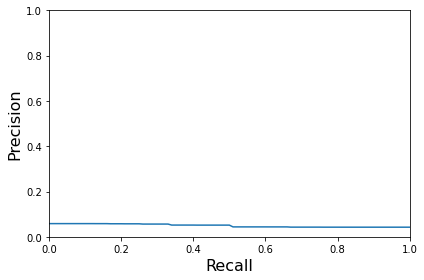

In [26]:
n = 0
d=0
recalls = np.arange(0, 1.01, .01)
ns = []
prediction = sorted(occurences.keys(), key=lambda x: occurences[x])[::-1]
print(prediction)
occurences = {k: 0 for k in label_dict_keys}
for row in pd.read_csv(test_dataset_path,sep=',', header = None).to_numpy():
    label, description=row[0], row[1]
    label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
    label_vectors = set([i for i in label_vectors if i in label_dict_keys])
    if label_vectors == set():
        continue
    #if(sum([occurences[i] for i in label_vectors]) >= len(label_vectors)):
    #    continue
    for i in label_vectors:
        occurences[i] += 1
    e = [1 if i in label_vectors else 0 for i in prediction]
    cur = []
    total_ones = e.count(1)
    n = 0
    ones_seen = 0
    while ones_seen < total_ones:
        if e[n] == 1:
            ones_seen = ones_seen+1
        n = n+1
        cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
    new_cur = []
    for r in recalls:
        max_of_larger = max([i[0] for i in cur if i[1] >= r])
        new_cur.append(max_of_larger)
    ns.append(new_cur)

p_baseline = np.mean(np.array(ns), axis=0)
import matplotlib.pyplot as plt
plt.plot(recalls, p_baseline)
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.margins(0.1)
#plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
plt.ylabel('Precision', fontsize=16)
plt.xlabel('Recall', fontsize=16)
plt.tight_layout()
plt.show()

546/546 [==============================] - 49s 90ms/step


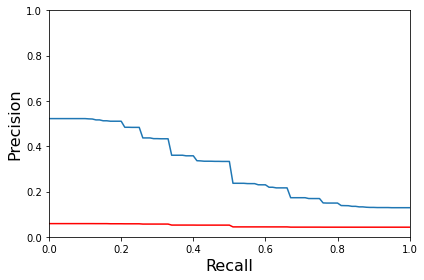

<Figure size 432x288 with 0 Axes>

In [34]:
def generate_prc():
    label_len = len(label_dict_keys)
    #print(label_len)
    left = [label_dict[i] for i in label_dict_keys]
    predictions = []
    left_vectors = np.array(list(label_dict_keys))
    label_vectors_vector = []
    num_tests = 546
    def cur_gen():
        current_dataframe = pd.read_csv(test_dataset_path,sep=',', header = None).to_numpy()#, chunksize=100000)
        indices = np.random.choice(len(current_dataframe), len(current_dataframe)-1)
        for row in current_dataframe[indices]:
            label, description=row[0], row[1]
            label_vectors = [z.strip().strip('\'\"')[:label_depth] for z in label.split(',')]
            label_vectors = set([i for i in label_vectors if i in label_dict_keys])
            if label_vectors == set():
                continue
            label_vectors_vector.append(label_vectors)
            lstm_input_patent =  get_sentence_vector(description.lower(), num_words)
            for i in left:
                yield ({'input_1':lstm_input_patent, 'input_2':i})

    dataset = tf.data.Dataset.from_generator(cur_gen, ({'input_1':tf.float64, 'input_2':tf.float64}), ({'input_1':tf.TensorShape([num_words, embedding_dim]), 'input_2':tf.TensorShape([num_words_description, embedding_dim])}))
    dataset = dataset.batch(label_len).prefetch(50)
    predictions = model.predict(dataset, steps=num_tests, verbose=1).reshape(num_tests, label_len)
    n = 0
    d=0
    recalls = np.arange(0, 1.01, .01)
    ns = []
    
    for prediction, label_vectors in zip(predictions, label_vectors_vector):
        indices = np.flip(np.argsort(prediction, axis=0))
        #print(indices)
        e = [1 if i in label_vectors else 0 for i in left_vectors[indices]]
        cur = []
        total_ones = e.count(1)
        n = 0
        ones_seen = 0
        while ones_seen < total_ones:
            if e[n] == 1:
                ones_seen = ones_seen+1
            n = n+1
            cur.append((ones_seen/float(n), ones_seen/float(total_ones)))
        new_cur = []
        for r in recalls:
            max_of_larger = max([i[0] for i in cur if i[1] >= r])
            new_cur.append(max_of_larger)
        ns.append(new_cur)
        #print(max(new_cur))
        d = d+1
        #print(float(d)/7215)
        #print(np.mean(np.vstack(ns), axis=0)[0])
    p = np.mean(np.array(ns), axis=0)
    import matplotlib.pyplot as plt
    plt.plot(recalls, p)
    plt.plot(recalls, p_baseline, 'r')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.margins(0.1)
    #plt.xticks(range(len(distribution_dict.keys()))[::50], new_x[::50], rotation='vertical')
    plt.ylabel('Precision', fontsize=16)
    plt.xlabel('Recall', fontsize=16)
    plt.tight_layout()
    plt.show()
    #print(p) 
    plt.savefig('binary_prc1.eps', format='eps')
generate_prc()

Epoch 1/50
3000/3000 [==============================] - ETA: 0s - loss: 0.3103 - accuracy: 0.8837
Epoch 00001: saving model to ../checkpoints/LSTMWithoutAttention-V1NewDataset.h5
546/546 [==============================] - 64s 117ms/step


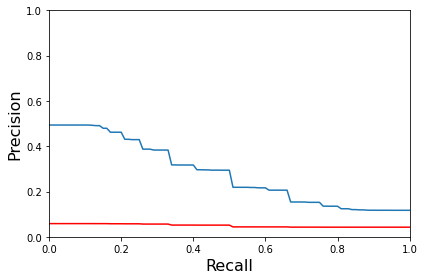

3000/3000 [==============================] - 459s 153ms/step - loss: 0.3103 - accuracy: 0.8837
Epoch 2/50
3000/3000 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8553
Epoch 00002: saving model to ../checkpoints/LSTMWithoutAttention-V1NewDataset.h5
546/546 [==============================] - 47s 87ms/step


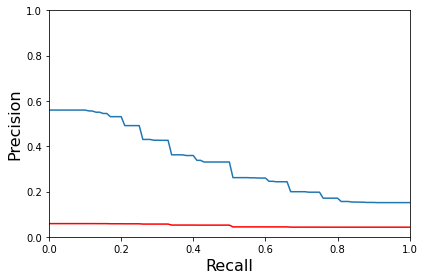

3000/3000 [==============================] - 2110s 703ms/step - loss: 0.3692 - accuracy: 0.8553
Epoch 3/50
3000/3000 [==============================] - ETA: 0s - loss: 0.3071 - accuracy: 0.8835
Epoch 00003: saving model to ../checkpoints/LSTMWithoutAttention-V1NewDataset.h5
546/546 [==============================] - 55s 100ms/step


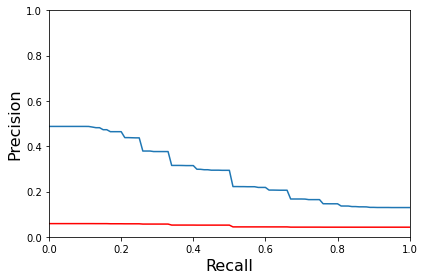

3000/3000 [==============================] - 486s 162ms/step - loss: 0.3071 - accuracy: 0.8835
Epoch 4/50
2275/3000 [=====================>........] - ETA: 9:03 - loss: 0.3607 - accuracy: 0.8585

In [ ]:
history = model.fit(lstm_dataset, epochs=50, steps_per_epoch=3000, callbacks=[cp_callback, prc_callback])

In [ ]:

generate_prc(100)